<a href="https://colab.research.google.com/github/henriqueburis/sinalizacao_horizonta_object-detection-fasterrcnn/blob/main/object_detection_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/teste.v2i.coco.zip

In [14]:
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [5]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [6]:
# our dataset is in cocoformat, we will need pypcoco tools
#!pip install pycocotools
from pycocotools.coco import COCO

In [7]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [8]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(500, 500), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(500, 500), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [9]:
class Dataset_Detection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [10]:
dataset_path = "/content/placas/"
seed = '15012024'

In [15]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'sinali', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'frente', 'supercategory': 'sinali'},
 2: {'id': 2, 'name': 'frente_esqueda', 'supercategory': 'sinali'},
 3: {'id': 3, 'name': 'frete_esqueda', 'supercategory': 'sinali'},
 4: {'id': 4, 'name': 'sinali', 'supercategory': 'sinali'}}

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

['sinali', 'frente', 'frente_esqueda', 'frete_esqueda', 'sinali']

In [17]:
train_dataset = Dataset_Detection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


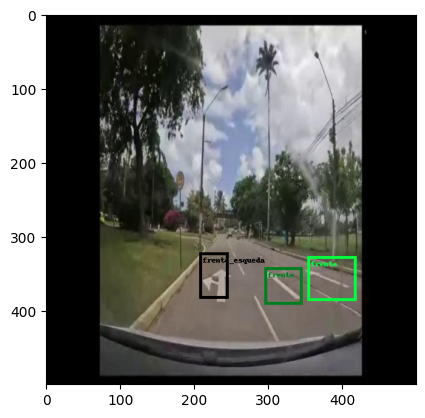

In [18]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [19]:
len(train_dataset)

24

In [20]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 130MB/s]


In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
def save_model(model):
    torch.save(model.state_dict(), dataset_path + "/"+str(seed)+"model.pth")

In [23]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [24]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [25]:
device = torch.device("cpu") # use GPU to train

In [26]:
model = model.to(device)

In [27]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [28]:
import sys

In [29]:
### train
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [30]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

save_model(model)

100%|██████████| 6/6 [01:11<00:00, 11.98s/it]


Epoch 0, lr: 0.010000, loss: 0.803319, loss_classifier: 0.482813, loss_box: 0.208428, loss_rpn_box: 0.008478, loss_object: 0.103600


100%|██████████| 6/6 [01:18<00:00, 13.04s/it]


Epoch 1, lr: 0.010000, loss: 0.734396, loss_classifier: 0.336151, loss_box: 0.373043, loss_rpn_box: 0.004932, loss_object: 0.020270


100%|██████████| 6/6 [00:59<00:00,  9.92s/it]


Epoch 2, lr: 0.010000, loss: 1.033746, loss_classifier: 0.456164, loss_box: 0.561449, loss_rpn_box: 0.005072, loss_object: 0.011060


100%|██████████| 6/6 [00:48<00:00,  8.09s/it]


Epoch 3, lr: 0.010000, loss: 1.174848, loss_classifier: 0.531783, loss_box: 0.630842, loss_rpn_box: 0.004395, loss_object: 0.007829


100%|██████████| 6/6 [00:57<00:00,  9.59s/it]


Epoch 4, lr: 0.010000, loss: 1.030174, loss_classifier: 0.546803, loss_box: 0.470028, loss_rpn_box: 0.004332, loss_object: 0.009011


100%|██████████| 6/6 [00:49<00:00,  8.33s/it]


Epoch 5, lr: 0.010000, loss: 0.963551, loss_classifier: 0.477360, loss_box: 0.474136, loss_rpn_box: 0.004264, loss_object: 0.007792


100%|██████████| 6/6 [00:46<00:00,  7.70s/it]


Epoch 6, lr: 0.010000, loss: 1.092228, loss_classifier: 0.507040, loss_box: 0.577400, loss_rpn_box: 0.003660, loss_object: 0.004128


100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


Epoch 7, lr: 0.010000, loss: 1.117308, loss_classifier: 0.545295, loss_box: 0.562447, loss_rpn_box: 0.002809, loss_object: 0.006757


100%|██████████| 6/6 [00:49<00:00,  8.25s/it]


Epoch 8, lr: 0.010000, loss: 0.832509, loss_classifier: 0.392536, loss_box: 0.430301, loss_rpn_box: 0.002696, loss_object: 0.006976


100%|██████████| 6/6 [00:47<00:00,  8.00s/it]


Epoch 9, lr: 0.010000, loss: 0.892090, loss_classifier: 0.419020, loss_box: 0.463739, loss_rpn_box: 0.002541, loss_object: 0.006790


##inference

In [31]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [32]:
test_dataset = Dataset_Detection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


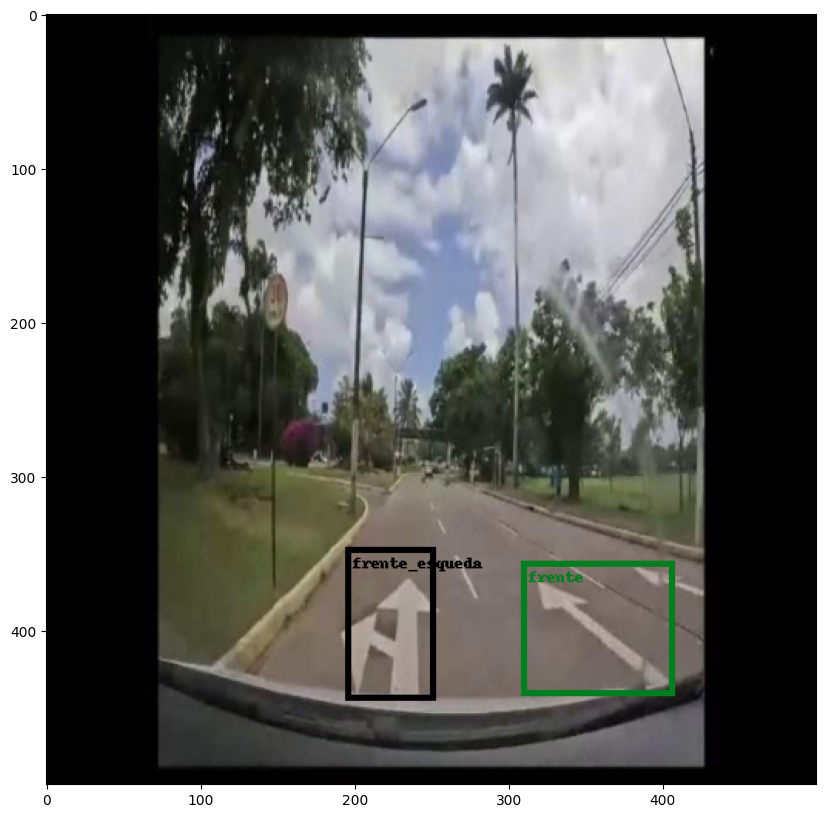

In [33]:
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]



fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))